## Análisis de datos - Clase 6

### Taller práctico - análisis completo de un dataset - parte 2

In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.decomposition import PCA

---
### Preparación para entrenamiento de un modelo de ML
---

#### Suponemos que queremos predecir quién va a ganar las próximas carreras y plantearemos un problema de clasificación binaria usando la variable "Winner" como target.

#### Importo el dataset

In [319]:
# Leer el JSON
with open("../datasets/carreras_24_1_dtypes.json", "r") as f:
    info = json.load(f)

dtypes_str = info["dtypes"]
categorical_cols = info["categoricals"]

# Detectar columnas especiales
parse_dates = [col for col, dtype in dtypes_str.items() if "datetime" in dtype]
timedeltas = [col for col, dtype in dtypes_str.items() if "timedelta" in dtype]

# Convertir strings de tipo a los tipos correctos
def convertir_dtype(dtype_str):
    if dtype_str.startswith("int"): return "Int64"
    if dtype_str.startswith("float"): return "float"
    if dtype_str == "object": return "string"
    if dtype_str == "bool": return "boolean"
    return "string"

normal_dtypes = {col: convertir_dtype(dtype) for col, dtype in dtypes_str.items()
                 if col not in parse_dates + timedeltas + categorical_cols}


# leer CSV
carreras_24 = pd.read_csv("../datasets/carreras_24_1.csv", parse_dates=parse_dates, dtype=normal_dtypes)


# Restaurar timedelta
for col in timedeltas:
    carreras_24[col] = pd.to_timedelta(carreras_24[col])

# Restaurar categoricals
for col in categorical_cols:
    carreras_24[col] = carreras_24[col].astype("category")


carreras_24.head()

,EventName,EventDate,Driver,DriverNumber,Team,PitInTime,PitOutTime,IsPersonalBest,Stint,LapTime,...,Humidity,Compound,TyreLife,FreshTyre,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,Bahrain Grand Prix,2024-03-02,VER,1,Red Bull Racing,NaT,NaT,False,1.0,97.284,...,49.0,SOFT,4.0,False,12,1.0,False,NaN,False,False
1,Bahrain Grand Prix,2024-03-02,LEC,16,Ferrari,NaT,NaT,False,1.0,98.271,...,49.0,SOFT,4.0,False,12,2.0,False,NaN,False,False
2,Bahrain Grand Prix,2024-03-02,RUS,63,Mercedes,NaT,NaT,False,1.0,99.228,...,49.0,SOFT,4.0,False,12,3.0,False,NaN,False,False
3,Bahrain Grand Prix,2024-03-02,NOR,4,McLaren,NaT,NaT,False,1.0,102.168,...,49.0,SOFT,4.0,False,12,7.0,False,NaN,False,False
4,Bahrain Grand Prix,2024-03-02,HAM,44,Mercedes,NaT,NaT,False,1.0,103.122,...,49.0,SOFT,4.0,False,12,9.0,False,NaN,False,False


In [320]:
carreras_24.columns

Index(['EventName', 'EventDate', 'Driver', 'DriverNumber', 'Team', 'PitInTime',
       'PitOutTime', 'IsPersonalBest', 'Stint', 'LapTime', 'LapNumber',
       'LapStartTime', 'LapStartDate', 'Sector1Time', 'Sector2Time',
       'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'AirTemp',
       'TrackTemp', 'Humidity', 'Compound', 'TyreLife', 'FreshTyre',
       'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

In [321]:
# Armo un dataset consolidado con los resultados de cada carrera para cada piloto

result = carreras_24.groupby(['Driver', 'EventName'], observed=True).agg(
    Event_date=('EventDate','first' ),
    Team=('Team','first'),
    Position_start=('Position', 'first'),
    Position_end=('Position', 'last'),
    Avg_LapTime=('LapTime', 'mean'),
    Fastest_LapTime=('LapTime', 'min'),
    AvgSpeedI1=('SpeedI1', 'mean'),
    AvgSpeedI2=('SpeedI2', 'mean'),
    Tyre_Compound_start=('Compound', 'first'),
    FreshTyre_start=('FreshTyre', 'first'),
    Avg_TrackTemp=('TrackTemp', 'mean'),
    Avg_AirTemp=('AirTemp', 'mean'),
    Avg_Humidity=('Humidity', 'mean'),

).reset_index()


# Agrego el ganador
result['Winner']= np.where(result['Position_end']==1,1,0)
result['Winner'] = result['Winner'].astype('category')
#result['Position_start'] = result['Position_start'].astype(float)
result = result.drop(['Position_end', 'EventName'], axis=1)

result.head()

,Driver,Event_date,Team,Position_start,Avg_LapTime,Fastest_LapTime,AvgSpeedI1,AvgSpeedI2,Tyre_Compound_start,FreshTyre_start,Avg_TrackTemp,Avg_AirTemp,Avg_Humidity,Winner
0,ALB,2024-12-08,Williams,16.0,91.307754,89.438,287.782609,297.508772,MEDIUM,True,30.682456,26.424561,54.894737,0
1,ALB,2024-03-24,Williams,14.0,84.769333,81.618,269.560000,304.210526,MEDIUM,True,38.550877,21.201754,43.245614,0
2,ALB,2024-06-30,Williams,15.0,72.480914,70.364,298.704918,223.814286,MEDIUM,True,46.418571,29.724286,34.328571,0
3,ALB,2024-09-15,Williams,9.0,110.254460,106.947,186.617021,200.784314,HARD,True,43.356863,26.501961,37.019608,0
4,ALB,2024-03-02,Williams,11.0,98.511214,95.723,231.395349,253.785714,SOFT,True,22.828571,18.012500,49.928571,0


In [322]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Driver               478 non-null    category      
 1   Event_date           478 non-null    datetime64[ns]
 2   Team                 478 non-null    category      
 3   Position_start       465 non-null    category      
 4   Avg_LapTime          465 non-null    float64       
 5   Fastest_LapTime      465 non-null    float64       
 6   AvgSpeedI1           465 non-null    float64       
 7   AvgSpeedI2           465 non-null    float64       
 8   Tyre_Compound_start  478 non-null    category      
 9   FreshTyre_start      478 non-null    category      
 10  Avg_TrackTemp        478 non-null    float64       
 11  Avg_AirTemp          478 non-null    float64       
 12  Avg_Humidity         478 non-null    float64       
 13  Winner               478 non-null  

In [323]:
result.head()

,Driver,Event_date,Team,Position_start,Avg_LapTime,Fastest_LapTime,AvgSpeedI1,AvgSpeedI2,Tyre_Compound_start,FreshTyre_start,Avg_TrackTemp,Avg_AirTemp,Avg_Humidity,Winner
0,ALB,2024-12-08,Williams,16.0,91.307754,89.438,287.782609,297.508772,MEDIUM,True,30.682456,26.424561,54.894737,0
1,ALB,2024-03-24,Williams,14.0,84.769333,81.618,269.560000,304.210526,MEDIUM,True,38.550877,21.201754,43.245614,0
2,ALB,2024-06-30,Williams,15.0,72.480914,70.364,298.704918,223.814286,MEDIUM,True,46.418571,29.724286,34.328571,0
3,ALB,2024-09-15,Williams,9.0,110.254460,106.947,186.617021,200.784314,HARD,True,43.356863,26.501961,37.019608,0
4,ALB,2024-03-02,Williams,11.0,98.511214,95.723,231.395349,253.785714,SOFT,True,22.828571,18.012500,49.928571,0


In [324]:
result = result.sort_values('Event_date').reset_index(drop=True)

result.head()

,Driver,Event_date,Team,Position_start,Avg_LapTime,Fastest_LapTime,AvgSpeedI1,AvgSpeedI2,Tyre_Compound_start,FreshTyre_start,Avg_TrackTemp,Avg_AirTemp,Avg_Humidity,Winner
0,OCO,2024-03-02,Alpine,16.0,98.860571,96.226,231.700000,253.535714,SOFT,True,22.826786,18.007143,49.946429,0
1,BOT,2024-03-02,Kick Sauber,18.0,98.503745,96.202,233.463415,253.125000,SOFT,True,22.823214,18.007143,49.964286,0
2,PIA,2024-03-02,McLaren,8.0,97.558316,94.774,235.025000,264.017544,SOFT,False,22.822807,18.007018,49.912281,0
3,ALO,2024-03-02,Aston Martin,6.0,97.888228,94.199,233.190476,247.894737,SOFT,False,22.824561,18.007018,49.912281,0
4,ZHO,2024-03-02,Kick Sauber,13.0,98.419661,95.458,233.350000,249.428571,SOFT,True,22.830357,18.012500,49.910714,0


---
### 1. Split del dataset
---

#### El split del dataset no lo debería hacer en forma aleatoria, porque tengo una fila por cada piloto para cada evento. Si hago un split random, puede que me queden filas para un mismo evento en test y train, y estaría haciendo data leakage. 
#### Para evitar esto, puedo hacer el split a partir de un cierto evento (por fecha). Un 80-20 se conseguiría tomando X_train = primeros 19 eventos del 2024 y X_test = últimos 5 eventos.

In [325]:
# Ordeno las fechas para hacer el split
np.sort(result['Event_date'].unique())

array(['2024-03-02T00:00:00.000000000', '2024-03-09T00:00:00.000000000',
       '2024-03-24T00:00:00.000000000', '2024-04-07T00:00:00.000000000',
       '2024-04-21T00:00:00.000000000', '2024-05-05T00:00:00.000000000',
       '2024-05-19T00:00:00.000000000', '2024-05-26T00:00:00.000000000',
       '2024-06-09T00:00:00.000000000', '2024-06-23T00:00:00.000000000',
       '2024-06-30T00:00:00.000000000', '2024-07-07T00:00:00.000000000',
       '2024-07-21T00:00:00.000000000', '2024-07-28T00:00:00.000000000',
       '2024-08-25T00:00:00.000000000', '2024-09-01T00:00:00.000000000',
       '2024-09-15T00:00:00.000000000', '2024-09-22T00:00:00.000000000',
       '2024-10-20T00:00:00.000000000', '2024-10-27T00:00:00.000000000',
       '2024-11-03T00:00:00.000000000', '2024-11-23T00:00:00.000000000',
       '2024-12-01T00:00:00.000000000', '2024-12-08T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [326]:
# Hago un split preliminar
fecha_split = pd.Timestamp('2024-10-27')

data_train = result[result['Event_date'] < fecha_split].copy()
data_test = result[result['Event_date'] >= fecha_split].copy()

# Datos para train
y_train_raw = data_train['Winner'].copy()
X_train_raw = data_train.drop(['Winner'], axis=1)

# Datos para test
y_test_raw = data_test['Winner'].copy()
X_test_raw = data_test.drop(['Winner'], axis=1)

# Verifico el split
print(f"últimas 5 filas de X_train: \n{X_train_raw['Event_date'].tail()}\n")
print(f"primeras 5 filas de X_test: \n{X_test_raw['Event_date'].head()}")

últimas 5 filas de X_train: 
374   2024-10-20
375   2024-10-20
376   2024-10-20
377   2024-10-20
378   2024-10-20
Name: Event_date, dtype: datetime64[ns]

primeras 5 filas de X_test: 
379   2024-10-27
380   2024-10-27
381   2024-10-27
382   2024-10-27
383   2024-10-27
Name: Event_date, dtype: datetime64[ns]


In [327]:
X_train_raw.columns

Index(['Driver', 'Event_date', 'Team', 'Position_start', 'Avg_LapTime',
       'Fastest_LapTime', 'AvgSpeedI1', 'AvgSpeedI2', 'Tyre_Compound_start',
       'FreshTyre_start', 'Avg_TrackTemp', 'Avg_AirTemp', 'Avg_Humidity'],
      dtype='object')

In [328]:
# Saco Event_date porque ya no me sirve (la usé solo para filtrar)
if 'Event_date' in X_train_raw.columns:
    X_train_raw = X_train_raw.drop(['Event_date'], axis=1)
if 'Event_date' in X_test_raw.columns:
    X_test_raw = X_test_raw.drop(['Event_date'], axis=1)

print(f"Dimensiones de X_train_raw:{X_train_raw.shape}")
print(f"Dimensiones de y_train_raw:{y_train_raw.shape}")
print(f"Dimensiones de X_test_raw:{X_test_raw.shape}")
print(f"Dimensiones de y_test_raw:{y_test_raw.shape}")

Dimensiones de X_train_raw:(379, 12)
Dimensiones de y_train_raw:(379,)
Dimensiones de X_test_raw:(99, 12)
Dimensiones de y_test_raw:(99,)


In [329]:
X_train_raw.columns

Index(['Driver', 'Team', 'Position_start', 'Avg_LapTime', 'Fastest_LapTime',
       'AvgSpeedI1', 'AvgSpeedI2', 'Tyre_Compound_start', 'FreshTyre_start',
       'Avg_TrackTemp', 'Avg_AirTemp', 'Avg_Humidity'],
      dtype='object')

Text(0.5, 1.0, 'Avg_AirTemp')

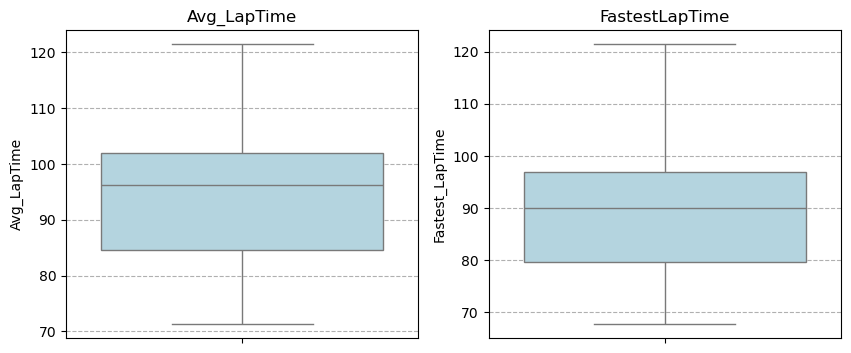

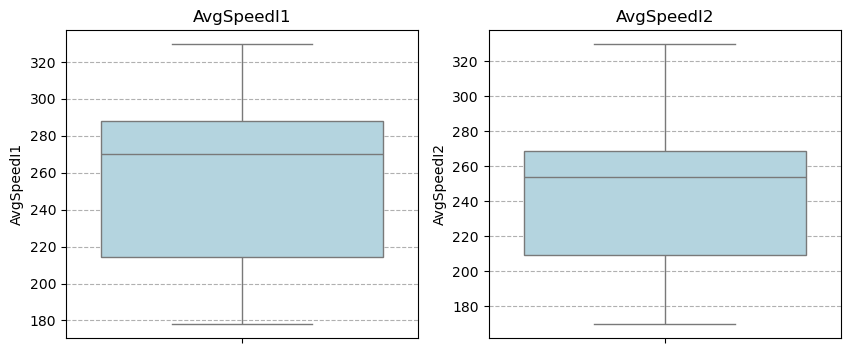

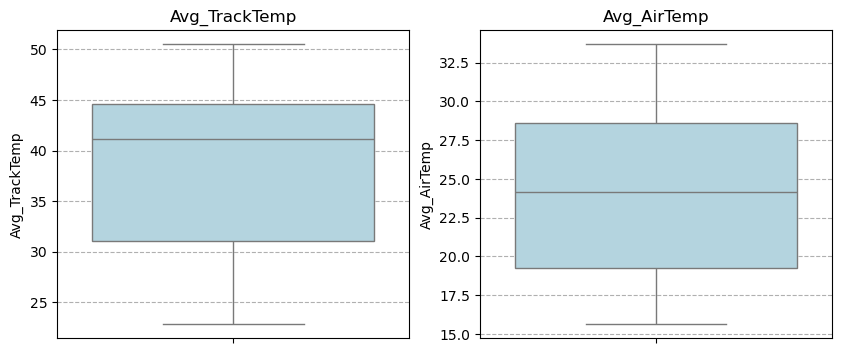

In [330]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(data=X_train_raw, y='Avg_LapTime', color="lightblue", ax=ax[0])
sns.boxplot(data=X_train_raw, y='Fastest_LapTime', color="lightblue", showfliers= False, ax=ax[1])       
ax[0].grid(axis='y', ls='--')
ax[0].set_title('Avg_LapTime', fontsize=12)
ax[1].grid(axis='y', ls='--')
ax[1].set_title('FastestLapTime', fontsize=12)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(data=X_train_raw, y='AvgSpeedI1', color="lightblue", ax=ax[0])
sns.boxplot(data=X_train_raw, y='AvgSpeedI2', color="lightblue", showfliers= False, ax=ax[1])       
ax[0].grid(axis='y', ls='--')
ax[0].set_title('AvgSpeedI1', fontsize=12)
ax[1].grid(axis='y', ls='--')
ax[1].set_title('AvgSpeedI2', fontsize=12)


ig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(data=X_train_raw, y='Avg_TrackTemp', color="lightblue", ax=ax[0])
sns.boxplot(data=X_train_raw, y='Avg_AirTemp', color="lightblue", showfliers= False, ax=ax[1])       
ax[0].grid(axis='y', ls='--')
ax[0].set_title('Avg_TrackTemp', fontsize=12)
ax[1].grid(axis='y', ls='--')
ax[1].set_title('Avg_AirTemp', fontsize=12)

 ---
 #### Implementación de pipeline para preprocesamiento
 ---


#### Scikit-learn tiene una función muy interesante que arma una pipeline para hacer el procesamiento más fácil y en un solo paso. A continuación vamos a mostrar cómo la utilizaríamos en este caso.

In [ ]:
numericas = [
    'Avg_LapTime', 'Fastest_LapTime', 'AvgSpeedI1', 'AvgSpeedI2',
    'Avg_TrackTemp', 'Avg_AirTemp', 'Avg_Humidity'
]

ordinales = ['Position_start']

nominales = ['Driver', 'Team', 'Tyre_Compound_start', 'FreshTyre_start']


print(f"\nVariables numéricas: {numericas}")
print(f"Ordinales: {ordinales}")
print(f"Variables nominales (cardinalidad media): {nominales}")



Variables numéricas: ['Avg_LapTime', 'Fastest_LapTime', 'AvgSpeedI1', 'AvgSpeedI2', 'Avg_TrackTemp', 'Avg_AirTemp', 'Avg_Humidity']
Ordinales: ['Position_start']
Variables nominales (cardinalidad media): ['Driver', 'Team', 'Tyre_Compound_start', 'FreshTyre_start']


In [332]:
X_train_raw.head(100)

,Driver,Team,Position_start,Avg_LapTime,Fastest_LapTime,AvgSpeedI1,AvgSpeedI2,Tyre_Compound_start,FreshTyre_start,Avg_TrackTemp,Avg_AirTemp,Avg_Humidity
0,OCO,Alpine,16.0,98.860571,96.226,231.700000,253.535714,SOFT,True,22.826786,18.007143,49.946429
1,BOT,Kick Sauber,18.0,98.503745,96.202,233.463415,253.125000,SOFT,True,22.823214,18.007143,49.964286
2,PIA,McLaren,8.0,97.558316,94.774,235.025000,264.017544,SOFT,False,22.822807,18.007018,49.912281
3,ALO,Aston Martin,6.0,97.888228,94.199,233.190476,247.894737,SOFT,False,22.824561,18.007018,49.912281
4,ZHO,Kick Sauber,13.0,98.419661,95.458,233.350000,249.428571,SOFT,True,22.830357,18.012500,49.910714
...,...,...,...,...,...,...,...,...,...,...,...,...
95,SAR,Williams,20.0,109.601143,101.000,261.840000,253.196429,SOFT,True,29.214286,18.553571,66.571429
96,RIC,RB,15.0,113.897188,100.994,259.821429,243.060606,MEDIUM,True,30.027273,18.727273,66.000000
97,OCO,Alpine,12.0,109.202964,100.937,256.075000,249.660714,MEDIUM,True,29.228571,18.555357,66.553571
98,RUS,Mercedes,6.0,107.987909,100.112,263.895833,259.642857,MEDIUM,True,29.230357,18.551786,66.517857


In [333]:
X_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 379 entries, 0 to 378
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Driver               379 non-null    category
 1   Team                 379 non-null    category
 2   Position_start       372 non-null    category
 3   Avg_LapTime          372 non-null    float64 
 4   Fastest_LapTime      372 non-null    float64 
 5   AvgSpeedI1           372 non-null    float64 
 6   AvgSpeedI2           372 non-null    float64 
 7   Tyre_Compound_start  379 non-null    category
 8   FreshTyre_start      379 non-null    category
 9   Avg_TrackTemp        379 non-null    float64 
 10  Avg_AirTemp          379 non-null    float64 
 11  Avg_Humidity         379 non-null    float64 
dtypes: category(5), float64(7)
memory usage: 27.6 KB


Consideraciones:

Transformaciones a las numéricas:
* SimpleImputer con imputación con la mediana.
* QuantileTransformer para manejo de outliers 'output_distribution='normal'' tranformándolos a una normal.

Transformaciones categóricas:
* SimpleImputer con imputación por moda para los valores faltantes de las categóricas.
* OneHotEncoder para codificarlas

Defino pipelines intermedias para transformar grupos de variables:

In [334]:
transformar_numericas = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # No lo aplicamos por no tener outliers, pero aquí hay un ejemplo que se podría aplicar:
    #('outlier_handler', QuantileTransformer(output_distribution='normal'))
    ('scaler', StandardScaler())
])

transformar_ordinales = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # SimpleImputer needs numeric input now
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())
])

# Esta función fuerza el tipo de datos a string
def convertir_a_string(X):
    return X.astype(str)

transformar_nominales = Pipeline(steps=[
    # El primer paso a string lo agregué porque me daba un error 
    # de tipo de dato las categóricas y con esto lo fuerzo
    ('to_str', FunctionTransformer(convertir_a_string, validate=False)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

Crear la función que hace el preprocesamiento (contiene las pipelines intermedias)

In [335]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformar_numericas, numericas),
        ('ord', transformar_ordinales, ordinales),
        ('nom', transformar_nominales, nominales)
    ],
    remainder='drop'
)

Crear la pipeline más grande:

In [336]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline.fit(X_train_raw, y_train_raw) # y_train_raw lo necesita para el target encoder

pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Avg_LapTime',
                                                   'Fastest_LapTime',
                                                   'AvgSpeedI1', 'AvgSpeedI2',
                                                   'Avg_TrackTemp',
                                                   'Avg_AirTemp',
                                                   'Avg_Humidity']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ordinal',
                                                                   Ord...oded_value',
                                                                                  unknown_value=-1)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Position_start']),
                                                 ('nom',
                                                  Pipeline(steps=[('to_str',
                                                                   FunctionTransformer(func=<function convertir_a_string at 0x1696ffd80>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Driver', 'Team',
                                                   'Tyre_Compound_start',
                                                   'FreshTyre_start'])]))])

In [337]:
X_train_procesado = pipeline.transform(X_train_raw)
X_test_procesado = pipeline.transform(X_test_raw)

In [338]:
print(f"\nShape de X_train_procesado: {X_train_procesado.shape}")
print(f"Shape de X_test_procesado: {X_test_procesado.shape}")


Shape de X_train_procesado: (379, 48)
Shape de X_test_procesado: (99, 48)


In [339]:
type(X_train_procesado)

scipy.sparse._csr.csr_matrix

Verificamos qué hizo - hay que reconstruir el DF

In [340]:
# Convertimos el resultado a un DataFrame:

pasos_preprocesador_ajustado = pipeline.named_steps['preprocessor'] # Accedemos a los nombres de los pasos de la pipeline

numericas_salida = numericas # las numéricas transformadas
ordinales_salida = ordinales # las ordinales transformadas


# Me paro en la pipeline de transformación de las nominales
pasos_pipeline_nominal = pasos_preprocesador_ajustado.named_transformers_['nom'] 

# Ahora acceso al one-hot encoder adentro de la pipeline nominal
pasos_onehot_encoder = pasos_pipeline_nominal.named_steps['onehot'] # Me meto adentro de la pipeline nominal

# Ahora me traigo los nuevos nombres de variables creados por el one-hot
features_salida_onehot = pasos_onehot_encoder.get_feature_names_out(nominales)

# Armamos los nombres de las variables en orden de acuerdo a la pipeline
transformed_feature_names = (
    list(numericas_salida) +
    list(ordinales_salida) +
    list(features_salida_onehot)
)

# Reconstruimos el dataframe procesado
X_train_preproc = pd.DataFrame(X_train_procesado.toarray(), columns=transformed_feature_names)
X_test_preproc = pd.DataFrame(X_test_procesado.toarray(), columns=transformed_feature_names)

X_train_preproc.head()

,Avg_LapTime,Fastest_LapTime,AvgSpeedI1,AvgSpeedI2,Avg_TrackTemp,Avg_AirTemp,Avg_Humidity,Position_start,Driver_ALB,Driver_ALO,...,Team_RB,Team_Red Bull Racing,Team_Williams,Tyre_Compound_start_HARD,Tyre_Compound_start_INTERMEDIATE,Tyre_Compound_start_MEDIUM,Tyre_Compound_start_SOFT,Tyre_Compound_start_WET,FreshTyre_start_False,FreshTyre_start_True
0,0.409923,0.697628,-0.645449,0.143383,-1.867030,-1.224642,-0.224930,0.950399,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.378977,0.695443,-0.602074,0.133428,-1.867476,-1.224642,-0.223584,1.304057,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.296983,0.565446,-0.563664,0.397465,-1.867527,-1.224667,-0.227503,-0.464235,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.325595,0.513101,-0.608787,0.006645,-1.867308,-1.224667,-0.227503,-0.817893,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.371684,0.627714,-0.604864,0.043825,-1.866584,-1.223552,-0.227621,0.419911,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


---
#### 4. Selección de features
---

#### Información mutua

In [341]:
selector_mi = SelectKBest(score_func=mutual_info_classif, k=20)
selector_mi.fit(X_train_preproc, y_train_raw)

# Aplicar el filtro a train
X_train_selected = selector_mi.transform(X_train_preproc)
# Aplicar el filtro a test
X_test_selected = selector_mi.transform(X_test_preproc)

selected_indices = selector_mi.get_support()
selected_features = X_train_preproc.columns[selected_indices]
scores = selector_mi.scores_[selected_indices]
print("\nCaracterísticas seleccionadas (Inf. mutua):")
for feature, score in zip(selected_features, scores):
    print(f"{feature}: {score:.4f}")

print(f"\nShape del dataset de train después de la selección): {X_train_selected.shape}")
print(f"Shape del dataset de test después de la selección): {X_test_selected.shape}")



Características seleccionadas (Inf. mutua):
Avg_LapTime: 0.0045
Position_start: 0.0925
Driver_BEA: 0.0046
Driver_GAS: 0.0079
Driver_HUL: 0.0149
Driver_LEC: 0.0162
Driver_OCO: 0.0121
Driver_RIC: 0.0100
Driver_SAI: 0.0083
Driver_SAR: 0.0079
Driver_STR: 0.0164
Driver_VER: 0.0154
Team_Ferrari: 0.0222
Team_McLaren: 0.0173
Team_RB: 0.0099
Team_Red Bull Racing: 0.0226
Team_Williams: 0.0090
Tyre_Compound_start_SOFT: 0.0138
Tyre_Compound_start_WET: 0.0087
FreshTyre_start_True: 0.0145

Shape del dataset de train después de la selección): (379, 20)
Shape del dataset de test después de la selección): (99, 20)


---
#### 5. Extracción de features 
---

#### PCA

In [ ]:
# Aplicar PCA
pca = PCA(n_components=5)
#components = pca.fit_transform(X_train_preproc) # Hacer PCA sobre el dataset sin filtrar
components = pca.fit_transform(X_train_selected) # Hacer PCA sobre el dataset filtrado por inf. mutua

# Resultado como DataFrame para graficar o analizar
df_components = pd.DataFrame(components, columns=['PC1', 'PC2','PC3', 'PC4', 'PC5'])
df_components['Winner'] = y_train_raw


In [343]:
df_components

,PC1,PC2,PC3,PC4,PC5,Winner
0,1.024095,-0.348886,0.527443,0.160715,-0.176975,0
1,1.250800,-0.564134,0.512255,0.169726,-0.159034,0
2,-0.219550,0.521113,1.190354,-0.028298,-0.119732,0
3,-0.389166,0.688717,1.195714,0.092057,-0.167784,0
4,0.574935,-0.033081,0.559232,0.160476,-0.140410,0
...,...,...,...,...,...,...
374,1.551933,-0.230099,-0.394502,-0.049641,-0.418873,0
375,1.567460,-0.360226,-0.257144,-0.034389,-0.023035,0
376,0.951611,0.793025,-0.175193,-0.043541,0.000065,0
377,0.503302,0.491429,-0.219768,-0.060005,-0.003442,0


#### Graficamos dos componentes

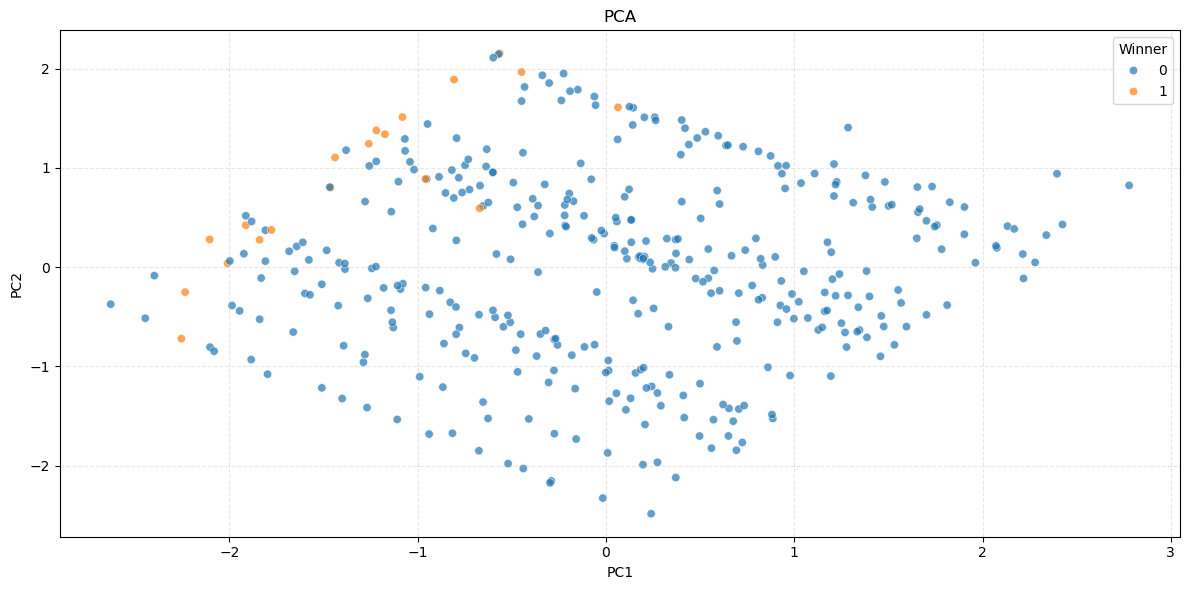

In [344]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_components, x='PC1', y='PC2', hue='Winner', alpha=0.7)
plt.title('PCA')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [345]:
# varianza explicada por cada componente
explained_var = pca.explained_variance_ratio_
explained_var

array([0.36499987, 0.2883105 , 0.05414695, 0.04519304, 0.03916963])

In [346]:
# varianza acumulada
cumulative_var = np.cumsum(explained_var)
cumulative_var

array([0.36499987, 0.65331037, 0.70745732, 0.75265036, 0.79181999])

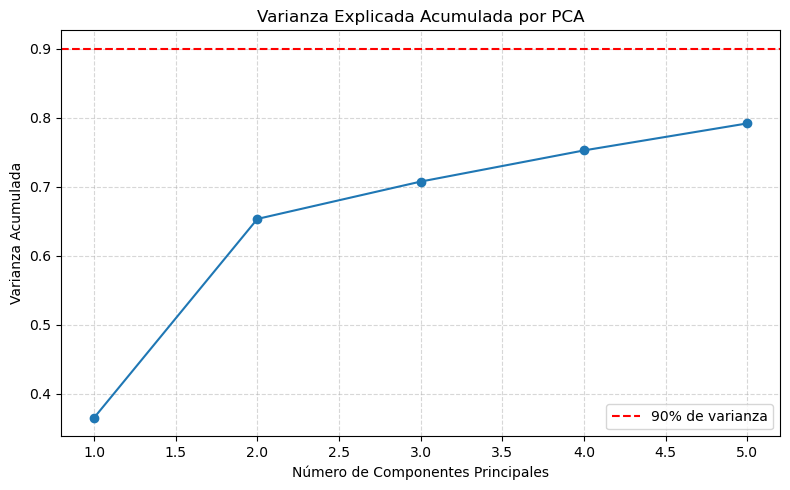

In [347]:
# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% de varianza')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


#### T-SNE y UMAP

In [348]:
from sklearn.manifold import TSNE

# Aplica t-SNE a 2 dimensiones
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
tsne_components = tsne.fit_transform(X_train_preproc)

# Crea un df con los componentes

df_tsne = pd.DataFrame(tsne_components, columns=['tSNE1', 'tSNE2', 'tSNE3'])
df_tsne['Winner'] = y_train_raw.values


In [349]:
import umap.umap_ as umap

# Aplica UMAP a  dimensiones
umap_model = umap.UMAP(n_components=5, random_state=42)
#umap_components = umap_model.fit_transform(X_train_preproc)
umap_components = umap_model.fit_transform(X_train_selected)

# Crea un df con los componentes
X_umap = pd.DataFrame(umap_components, columns=['UMAP1', 'UMAP2', 'UMAP3', 'UMAP4', 'UMAP5'])
X_umap['Winner'] = y_train_raw.values


/Users/ari/opt/miniconda3/envs/add-env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ari/opt/miniconda3/envs/add-env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


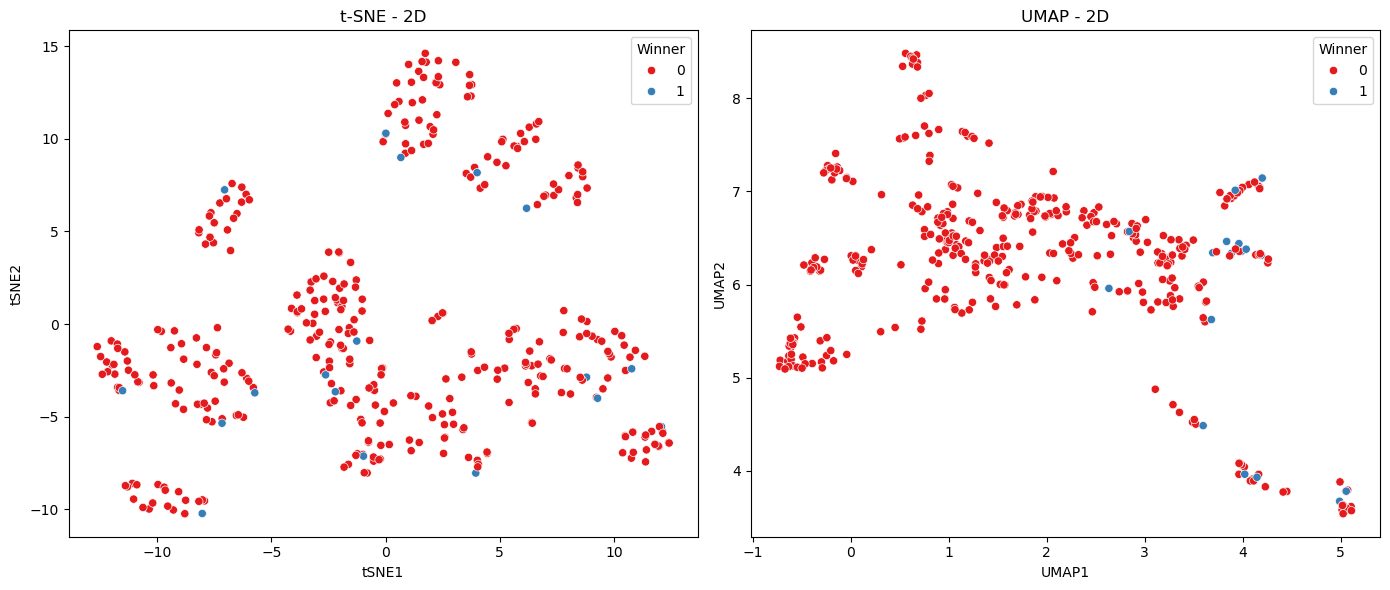

In [350]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# t-SNE
sns.scatterplot(data=df_tsne, x='tSNE1', y='tSNE2', hue='Winner', palette='Set1', ax=axes[0])
axes[0].set_title('t-SNE - 2D')

# UMAP
sns.scatterplot(data=X_umap, x='UMAP1', y='UMAP2', hue='Winner', palette='Set1', ax=axes[1])
axes[1].set_title('UMAP - 2D')

plt.tight_layout()
plt.show()


In [351]:
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(X_umap, y_train_raw)
print(f"Silhouette Score: {sil_score:.2f}")

Silhouette Score: 0.16
